# Imports

In [1]:
import pandas as pd
# disable chained assignments
pd.options.mode.chained_assignment = None 
import os, gc

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime

from models import *
from plotter import *
from utils import *
from splits import *
from best_config import *

SEED = 7
tf.random.set_seed(SEED)
SHOW_IMAGE = False
VERBOSE = 1
Split = Baseline

## Result folder

In [2]:
output_folder = 'scratch/top_100'
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

# Preprocessing

In [3]:
df = pd.read_csv('../TFT-pytorch/2022_May_cleaned/Top_100.csv')
df['Date'] = pd.to_datetime(df['Date'])
print(df.head(3))

   FIPS  AgeDist  HealthDisp       Date  DiseaseSpread  Transmission  \
0  2261    0.014         8.8 2020-02-29            0.0           0.0   
1  2261    0.014         8.8 2020-03-01            0.0           0.0   
2  2261    0.014         8.8 2020-03-02            0.0           0.0   

   VaccinationFull  SocialDist  Cases  TimeFromStart  SinWeekly  CosWeekly  
0              0.0         0.5    0.0              0     -0.975     -0.223  
1              0.0         0.5    0.0              1     -0.782      0.623  
2              0.0         0.5    0.0              2      0.000      1.000  


## Config

In [4]:
@dataclass
class Config:
    static_features = ['AgeDist', 'HealthDisp']
    past_features = ['DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist']
    known_future = ['SinWeekly', 'CosWeekly']
    time_index = 'TimeFromStart' # note that this is an index feature commonly used by all timeseries models

    features =  [time_index] + static_features + past_features + known_future
    targets = ['Cases']
    group_id = 'FIPS'
    selected_columns = features + targets
    input_sequence_length = 13
    output_sequence_length = 15
    batch_size = 64
    buffer_size = 1000
    epochs = 1
    learning_rate = 1e-6
    early_stopping_patience = 5
    loss = 'mse'

    # learning_rate = LstmConfig.learning_rate
    # batch_size = LstmConfig.batch_size

targets = Config.targets
group_id = Config.group_id
input_sequence_length = Config.input_sequence_length
output_sequence_length = Config.output_sequence_length

## Split and scale

In [5]:
train_df, val_df, test_df = split_data(df, Split, input_sequence_length)
train_df, val_df, test_df, feature_scaler, target_scaler = scale_data(
    train_df, val_df, test_df, Config.features, targets
)

Shapes: train (64000, 12), validation (2800, 12), test (2800, 12).


## Window generator

In [6]:
x_train, y_train = prepare_dataset(
    train_df, Config, disable_progress_bar=(VERBOSE!=1)
)
x_val, y_val = prepare_dataset(
    val_df, Config, disable_progress_bar=(VERBOSE!=1)
)
x_test, y_test = prepare_dataset(
    test_df, Config, disable_progress_bar=(VERBOSE!=1)
)

  0%|          | 0/100 [00:00<?, ?it/s]

Shapes: data (61300, 13, 10), labels (61300, 15).


  0%|          | 0/100 [00:00<?, ?it/s]

Shapes: data (100, 13, 10), labels (100, 15).


  0%|          | 0/100 [00:00<?, ?it/s]

Shapes: data (100, 13, 10), labels (100, 15).


## Tensors

In [7]:
train_data = cache_data(
    x_train, y_train, batch_size=Config.batch_size, 
    buffer_size=Config.buffer_size
)
val_data = cache_data(
    x_val, y_val, batch_size=Config.batch_size, 
)
test_data = cache_data(
    x_test, y_test, batch_size=Config.batch_size, 
)

# Training

## Model

In [8]:
output_size = len(targets) * output_sequence_length
model = build_LSTM(
    input_shape=x_train.shape[1:], output_size=output_size, loss=Config.loss, 
    learning_rate=Config.learning_rate,
    # hidden_size=LstmConfig.hidden_size, dropout=LstmConfig.dropout, 
    # layers=LstmConfig.layers
)
early_stopping = EarlyStopping(
    patience = Config.early_stopping_patience, 
    restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(output_folder, 'model.h5'), 
    save_best_only=True
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 13, 64)            19200     
                                                                 
 dropout (Dropout)           (None, 13, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 13, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 13, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 15)                975       
                                                                 
Total params: 86,223
Trainable params: 86,223
Non-traina

In [9]:
start = datetime.now()
print(f'\n----Training started at {start}----\n')
history = model.fit(
    train_data, epochs=Config.epochs, validation_data=val_data, 
    callbacks=[early_stopping, model_checkpoint],
    verbose=VERBOSE
)
gc.collect()
end = datetime.now()
print(f'\n----Training ended at {end}, elapsed time {end-start}.')


----Training started at 2023-01-21 19:42:56.266086----

958/958 [==============================] - 13s 10ms/step - loss: 1.0250 - val_loss: 0.9983

----Training ended at 2023-01-21 19:43:09.247382, elapsed time 0:00:12.981296.


In [10]:
print(f'Best model by validation loss saved at {model_checkpoint.filepath}.')
print(f'Loading best model.')
model.load_weights(model_checkpoint.filepath)

Best model by validation loss saved at scratch/top_100\model.h5.
Loading best model.


## History

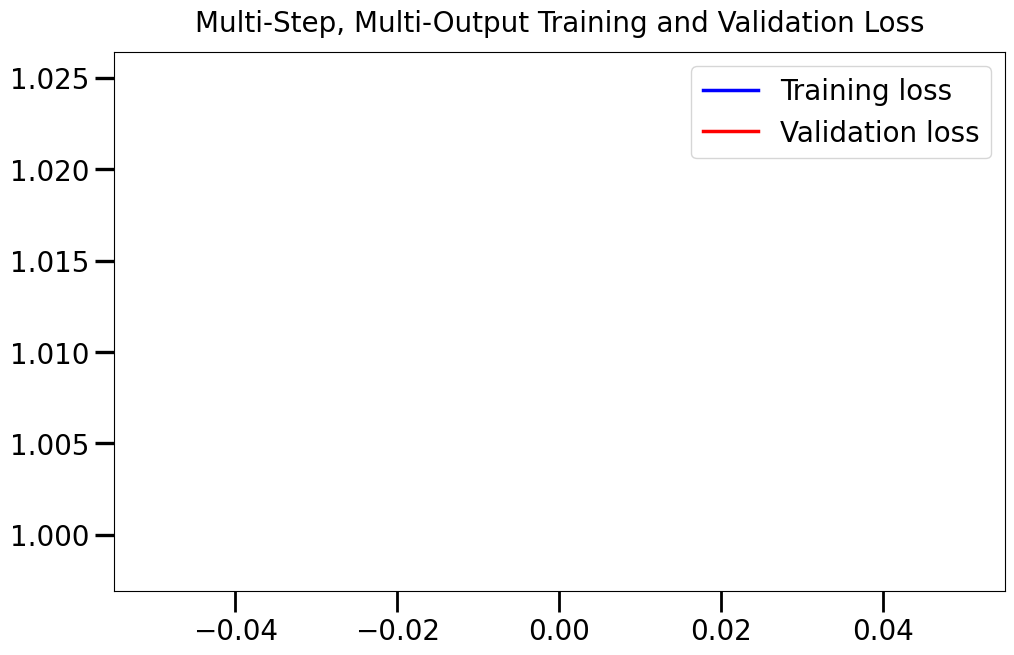

In [11]:
plot_train_history(
    history, title='Multi-Step, Multi-Output Training and Validation Loss', 
    figure_path=os.path.join(output_folder, 'history.jpg'), 
    show_image=SHOW_IMAGE
)

# Prediction

## Train data

In [12]:
print('\nTrain prediction')
train_data = cache_data(
    x_train, y_train, batch_size=Config.batch_size, 
)
y_pred = model.predict(train_data, verbose=VERBOSE)

# upscale prediction
y_pred = target_scaler.inverse_transform(
    y_pred.reshape((-1, len(targets)))
).reshape((-1, output_sequence_length, len(targets)))

# upscale ground truth
target_df = train_df[[group_id, 'Date'] + targets].copy().reset_index(drop=True)
target_df[targets] = target_scaler.inverse_transform(target_df[targets])

# align predictions with ground truth
train_prediction_df = process_prediction(target_df, y_pred, Config)
print(train_prediction_df.describe())


Train prediction
958/958 [==============================] - 6s 6ms/step
               FIPS         Cases  Predicted_Cases
count  62500.000000  62500.000000     62500.000000
mean   25826.550000    296.774200       290.662816
std    15937.120121    645.370118        12.352951
min     2261.000000      0.000000       232.000000
25%    12026.000000     37.000000       283.000000
50%    25023.000000    124.000000       290.000000
75%    39038.500000    324.000000       297.000000
max    55079.000000  20618.250000       363.000000


Target Cases, MAE 292.77, RMSE 642.28, RMSLE 2.4128, SMAPE 1.0388. NNSE 0.5024.



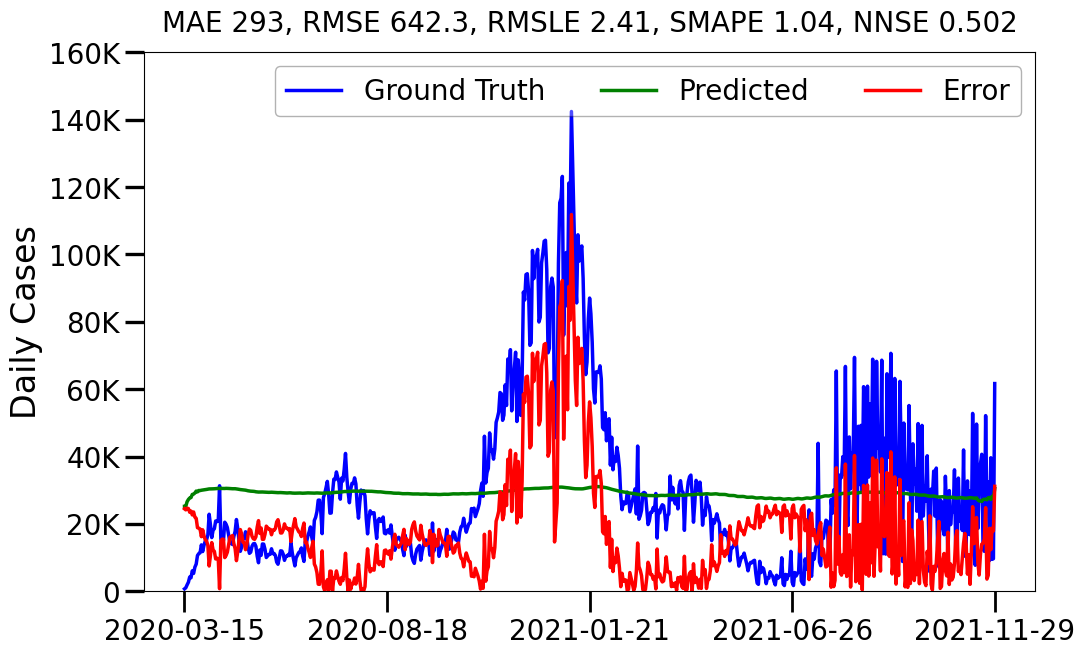

In [13]:
show_result(train_prediction_df, targets)
for target in targets:
    plot_predition(
        train_prediction_df, target, show_image=SHOW_IMAGE, plot_error=True,
        figure_path=os.path.join(output_folder, f'Summed_{target}_Train.jpg')
    )

## Validation data

In [14]:
print('\nValidation prediction')
y_pred = model.predict(val_data, verbose=VERBOSE)

# upscale prediction
y_pred = target_scaler.inverse_transform(
    y_pred.reshape((-1, len(targets)))
).reshape((-1, output_sequence_length, len(targets)))

# upscale ground truth
target_df = val_df[[group_id, 'Date'] + targets].copy().reset_index(drop=True)
target_df[targets] = target_scaler.inverse_transform(target_df[targets])

# align predictions with ground truth
val_prediction_df = process_prediction(target_df, y_pred, Config)
print(val_prediction_df.describe())


Validation prediction
2/2 [==============================] - 0s 10ms/step
               FIPS        Cases  Predicted_Cases
count   1300.000000  1300.000000      1300.000000
mean   25826.550000   409.419423       271.018462
std    15943.125775   652.366754        37.680104
min     2261.000000     0.000000       153.000000
25%    12026.000000     0.000000       248.000000
50%    25023.000000   196.500000       276.000000
75%    39038.500000   528.000000       296.000000
max    55079.000000  8204.000000       382.000000


Target Cases, MAE 367.23, RMSE 662.14, RMSLE 3.1994, SMAPE 1.1381. NNSE 0.49238.



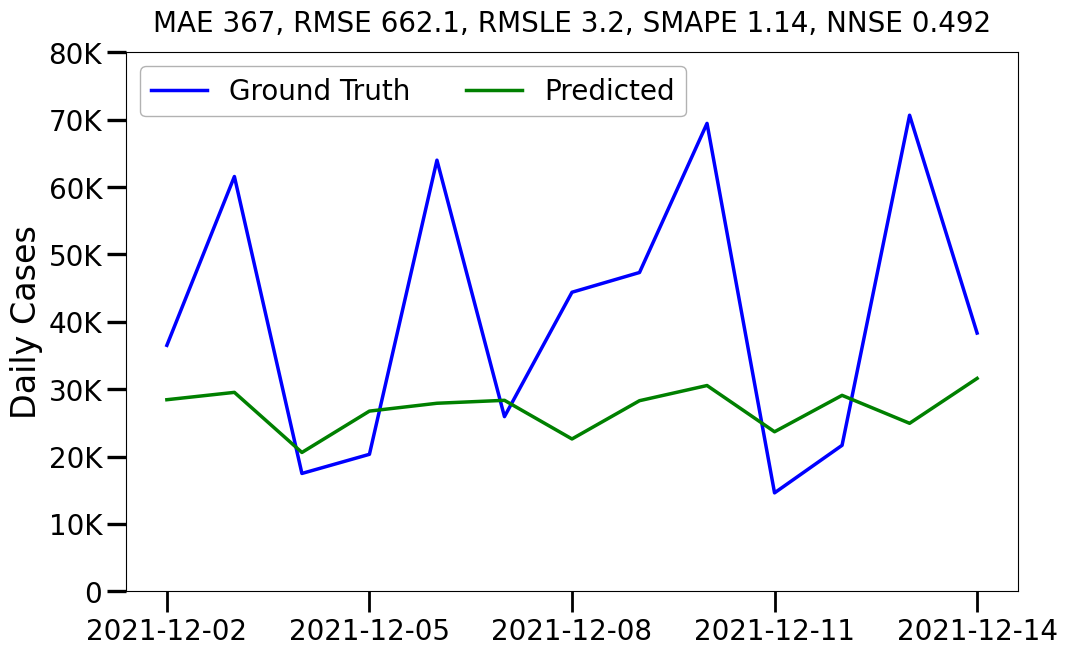

In [15]:
show_result(val_prediction_df, targets)
for target in targets:
    plot_predition(
        val_prediction_df, target, show_image=SHOW_IMAGE,
        figure_path=os.path.join(output_folder, f'Summed_{target}_Validation.jpg')
    )

## Test data

In [16]:
print('\nTest prediction')
y_pred = model.predict(test_data, verbose=VERBOSE)

# upscale prediction
y_pred = target_scaler.inverse_transform(
    y_pred.reshape((-1, len(targets)))
).reshape((-1, output_sequence_length, len(targets)))

# upscale ground truth
target_df = test_df[[group_id, 'Date'] + targets].copy().reset_index(drop=True)
target_df[targets] = target_scaler.inverse_transform(target_df[targets])

# align predictions with ground truth
test_prediction_df = process_prediction(target_df, y_pred, Config)
print(test_prediction_df.describe())


Test prediction
2/2 [==============================] - 0s 8ms/step
               FIPS         Cases  Predicted_Cases
count   1300.000000   1300.000000      1300.000000
mean   25826.550000    972.566923       273.866154
std    15943.125775   1556.938719        40.347668
min     2261.000000      0.000000       140.000000
25%    12026.000000      0.000000       248.000000
50%    25023.000000    469.000000       278.000000
75%    39038.500000   1253.750000       301.250000
max    55079.000000  20618.250000       398.000000


Target Cases, MAE 884.57, RMSE 1704, RMSLE 3.3369, SMAPE 1.3153. NNSE 0.45479.



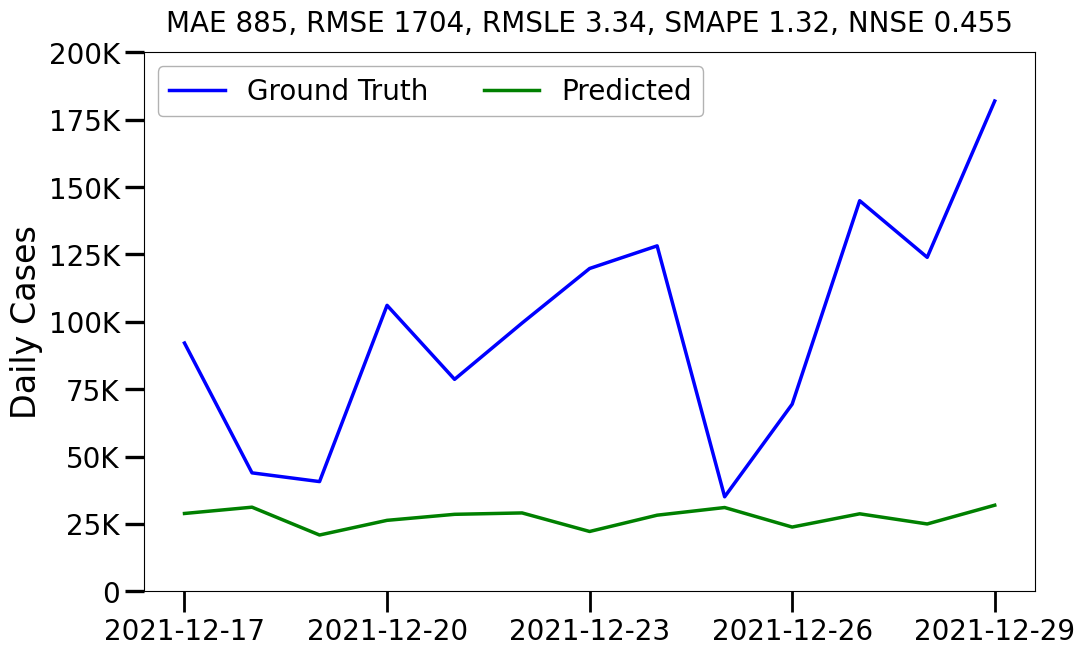

In [17]:
show_result(test_prediction_df, targets)
for target in targets:
    plot_predition(
        test_prediction_df, target=target, show_image=SHOW_IMAGE,
        figure_path=os.path.join(output_folder, f'Summed_{target}_Test.jpg')
    )

## Dump

In [18]:
train_prediction_df['Split'] = 'train'
val_prediction_df['Split'] = 'validation'
test_prediction_df['Split'] = 'test'
merged_df = pd.concat([train_prediction_df, val_prediction_df, test_prediction_df], axis=0)
merged_df.to_csv(os.path.join(output_folder, 'predictions.csv'), index=False)
print(f'Ended at {datetime.now()}. Elapsed time {datetime.now() - start}')

Ended at 2023-01-21 19:44:09.549435. Elapsed time 0:01:13.283349
